# Clean

In [660]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [661]:
df = pd.read_csv('credit_approval_realistic.csv')
df.head()

,customer_id,age,income,employment_years,credit_score,num_dependents,loan_amount,loan_term_months,loan_purpose,past_defaults,default
0,1,23,5818.0,6.0,760.0,3,30992.0,36,Home,0,1
1,2,49,3575.0,23.0,749.0,0,8455.0,24,Business,0,0
2,3,55,5182.0,10.0,631.0,4,26047.0,24,Business,0,1
3,4,59,5160.0,5.0,704.0,2,12016.0,36,Home,0,0
4,5,38,3253.0,17.0,634.0,2,18714.0,36,Home,0,0


In [662]:
print(df.columns)

Index(['customer_id', 'age', 'income', 'employment_years', 'credit_score',
       'num_dependents', 'loan_amount', 'loan_term_months', 'loan_purpose',
       'past_defaults', 'default'],
      dtype='object')


In [663]:
# Check imbalance
print("The default rate is: {:.2%}".format(df['default'].value_counts()[1] / len(df)))

The default rate is: 7.92%


In [664]:
# Numeric features
print(df.groupby('default').mean(numeric_only=True))

         customer_id        age       income  employment_years  credit_score  \
default                                                                        
0        5010.850456  42.422567  6054.715373         12.008914    679.829713   
1        4880.162879  41.702020  5653.234848         12.053097    668.752525   

         num_dependents   loan_amount  loan_term_months  past_defaults  
default                                                                 
0              2.003367  17554.494027         36.427454       0.239248  
1              2.006313  22553.953283         34.030303       0.287879  


Decent Signal: income, loan_amount
Weak Signal: credit_score, past_defaults

In [665]:
df.isna().sum()

customer_id          0
age                  0
income              10
employment_years    10
credit_score         0
num_dependents       0
loan_amount          0
loan_term_months     0
loan_purpose        10
past_defaults        0
default              0
dtype: int64

In [666]:
df = df.dropna()

In [667]:
df['loan_purpose'].value_counts()

loan_purpose
Home         2520
Car          2474
Education    2024
Business     1964
Other         978
Edcuation       4
Hmoe            3
Bussiness       1
Othre           1
Caar            1
Name: count, dtype: int64

In [668]:
category = ['Home', 'Car', 'Education', 'Business', 'Other']
df = df[df['loan_purpose'].isin(category)]

In [669]:
# Recheck
print("The default rate is: {:.2%}".format(df['default'].value_counts()[1] / len(df)))
print(df.groupby('default').mean(numeric_only=True))

The default rate is: 7.89%
         customer_id        age       income  employment_years  credit_score  \
default                                                                        
0        5011.117833  42.432091  6053.925223         12.012535    679.790604   
1        4867.372774  41.625954  5664.641221         12.045802    668.618321   

         num_dependents   loan_amount  loan_term_months  past_defaults  
default                                                                 
0              2.004905  17556.097558         36.427731       0.239045  
1              2.008906  22538.372774         34.045802       0.290076  


In [670]:
encode_category = pd.get_dummies(df['loan_purpose'], dtype=int)
print(encode_category)

      Business  Car  Education  Home  Other
0            0    0          0     1      0
1            1    0          0     0      0
2            1    0          0     0      0
3            0    0          0     1      0
4            0    0          0     1      0
...        ...  ...        ...   ...    ...
9994         0    0          1     0      0
9995         0    1          0     0      0
9997         0    1          0     0      0
9998         0    0          1     0      0
9999         1    0          0     0      0

[9960 rows x 5 columns]


In [671]:
df_final = pd.concat([df.drop('loan_purpose', axis=1), encode_category], axis=1)

In [672]:
df_final.head()

,customer_id,age,income,employment_years,credit_score,num_dependents,loan_amount,loan_term_months,past_defaults,default,Business,Car,Education,Home,Other
0,1,23,5818.0,6.0,760.0,3,30992.0,36,0,1,0,0,0,1,0
1,2,49,3575.0,23.0,749.0,0,8455.0,24,0,0,1,0,0,0,0
2,3,55,5182.0,10.0,631.0,4,26047.0,24,0,1,1,0,0,0,0
3,4,59,5160.0,5.0,704.0,2,12016.0,36,0,0,0,0,0,1,0
4,5,38,3253.0,17.0,634.0,2,18714.0,36,0,0,0,0,0,1,0


# Model Comparison

In [673]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [674]:
# Train-Test
X = df_final.drop(columns=['customer_id', 'default'])
y = df_final['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    random_state=42,
    stratify=y
)

In [675]:
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Logistic Regression

In [676]:
model_lr = LogisticRegression(
    random_state=42, 
    class_weight='balanced'
)
start_time = time.time()
model_lr.fit(scaled_X_train, y_train)
end_time = time.time()

print(end_time - start_time)

0.006512880325317383


Let's say that the cost ratio is around 8:1.

In [677]:
y_prob = model_lr.predict_proba(scaled_X_test)[:, 1]
y_pred = (y_prob > 0.56).astype(int)

In [678]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.74      0.83      1835
           1       0.16      0.57      0.25       157

    accuracy                           0.73      1992
   macro avg       0.56      0.65      0.54      1992
weighted avg       0.89      0.73      0.79      1992



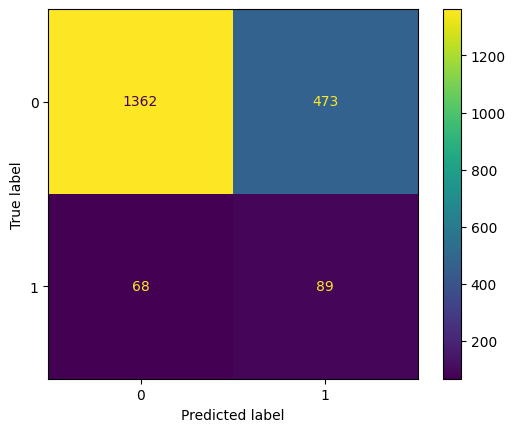

In [679]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot()
plt.show()

TN = Predicted not default and true
FP = Predicted default and false
FN = Predicted not default and false
TP = Predicted default and true

In [680]:
tn_lr, fp_lr, fn_lr, tp_lr = cm.ravel()

cost = fn_lr * 8 + fp_lr * 1
print(cost)

1017


When the class_weight is not adjusted, the ideal threshold is 0.1
When it is adjusted, the ideal threshold is 0.56

## Random Forest

In [681]:
model_rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced', 
    max_depth=15,
    min_samples_leaf=20,
    min_samples_split=100,
    max_features='sqrt'
    )
start_time = time.time()
model_rf.fit(scaled_X_train, y_train)
end_time = time.time()

print(end_time - start_time)

0.4435555934906006


In [682]:
y_prob = model_rf.predict_proba(scaled_X_test)[:, 1]
y_pred = (y_prob > 0.53).astype(int)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1835
           1       0.17      0.48      0.25       157

    accuracy                           0.78      1992
   macro avg       0.56      0.64      0.56      1992
weighted avg       0.89      0.78      0.82      1992



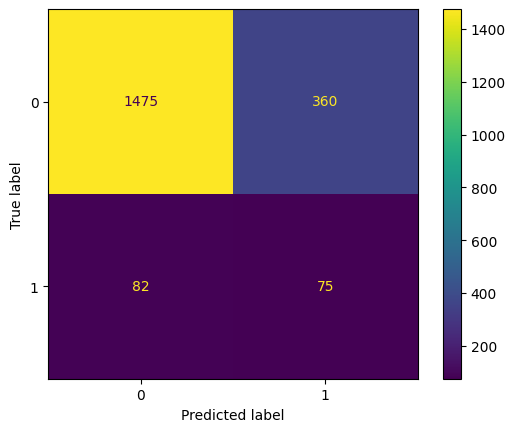

In [683]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot()
plt.show()

In [684]:
tn_rf, fp_rf, fn_rf, tp_rf = cm.ravel()

cost = fn_rf * 8 + fp_rf * 1
print(cost)

1016


## XGBoost

In [685]:
model_xg = XGBClassifier(
    n_estimators = 200,
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1]),
    max_depth = 3,
    learning_rate = 0.01,
    subsample = 0.6,
    colsample_bytree = 0.8
)
start_time = time.time()
model_xg.fit(scaled_X_train, y_train)
end_time = time.time()

print(end_time - start_time)

0.10654878616333008


In [686]:
y_prob = model_xg.predict_proba(scaled_X_test)[:, 1]
y_pred = (y_prob > 0.55).astype(int)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1835
           1       0.15      0.61      0.24       157

    accuracy                           0.69      1992
   macro avg       0.55      0.65      0.52      1992
weighted avg       0.89      0.69      0.76      1992



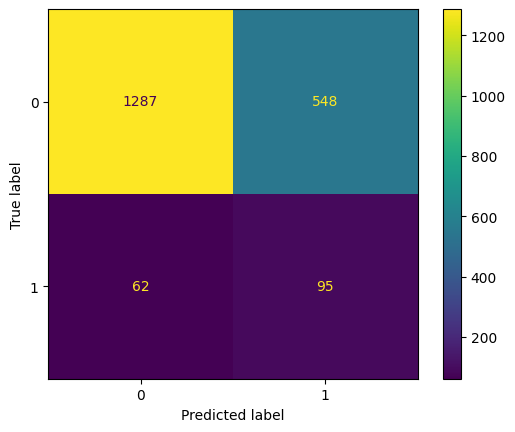

In [687]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot()
plt.show()

In [688]:
tn_xg, fp_xg, fn_xg, tp_xg = cm.ravel()

cost = fn_xg * 8 + fp_xg * 1
print(cost)

1044


## ROC Curve

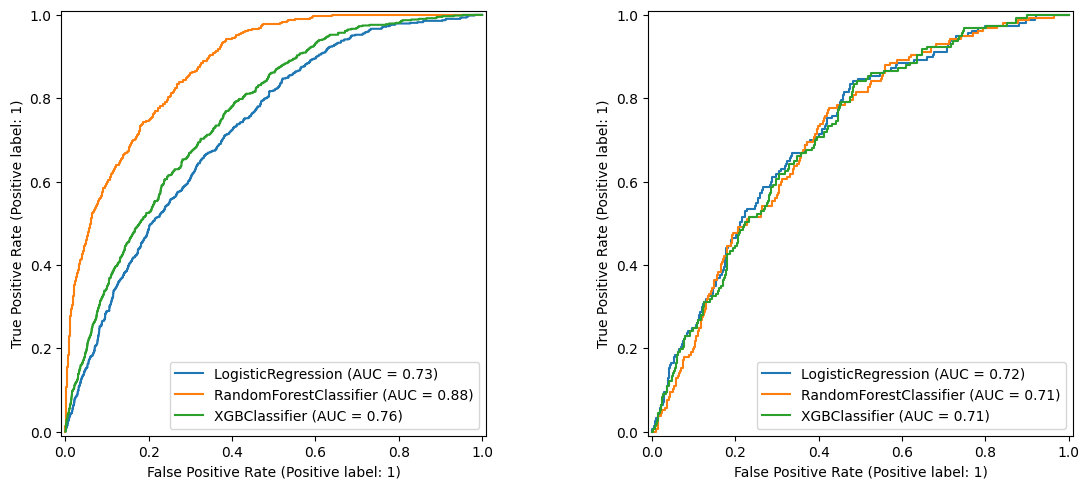

In [689]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
disp = RocCurveDisplay.from_estimator(model_lr, scaled_X_train, y_train, ax=axes[0])
disp = RocCurveDisplay.from_estimator(model_lr, scaled_X_test, y_test, ax=axes[1])
disp = RocCurveDisplay.from_estimator(model_rf, scaled_X_train, y_train, ax=axes[0])
disp = RocCurveDisplay.from_estimator(model_rf, scaled_X_test, y_test, ax=axes[1])
disp = RocCurveDisplay.from_estimator(model_xg, scaled_X_train, y_train, ax=axes[0])
disp = RocCurveDisplay.from_estimator(model_xg, scaled_X_test, y_test, ax=axes[1])
plt.tight_layout()
plt.show()

# Conclusion

In [690]:
# Avg loan
avg_loan = df['loan_amount'].mean() * 1000
print(f'The average loan is {avg_loan}')

The average loan is 17949277.108433735


In [691]:
# Under the assumption that the interest profit target is 12.5%
interest_profit = avg_loan * 0.125
print(f"The interest profit target is {interest_profit}")

The interest profit target is 2243659.638554217


In [692]:
# Prevented loss (TP)
prevent_loss = tp_lr * avg_loan

# Escaped loss (FN)
esc_loss = fn_lr * avg_loan

# Profit loss (FP)
profit_loss = fp_lr * interest_profit

prevent_loss = round(tp_lr * avg_loan)
esc_loss = round(fn_lr * avg_loan)
profit_loss = round(fp_lr * interest_profit)

print(f"Our model successfully detected {tp_lr} potential customers with a high risk of default. By rejecting them, it prevented a capital loss of Rp {prevent_loss:,}.")
print(f"Of course, this model isn't perfect. There were {fn_lr} delinquent customers who escaped because they were predicted to be smooth. This represents a capital loss risk of Rp {esc_loss:,}.")
print(f"Because we set the model to be more cautious (with balancing), we rejected {fp_lr} customers who were initially performing well. We didn't lose any capital from this, but we did lose potential interest profits of Rp {profit_loss:,}.")

Our model successfully detected 89 potential customers with a high risk of default. By rejecting them, it prevented a capital loss of Rp 1,597,485,663.
Of course, this model isn't perfect. There were 68 delinquent customers who escaped because they were predicted to be smooth. This represents a capital loss risk of Rp 1,220,550,843.
Because we set the model to be more cautious (with balancing), we rejected 473 customers who were initially performing well. We didn't lose any capital from this, but we did lose potential interest profits of Rp 1,061,251,009.


In [693]:
print(model_lr.coef_[0])

[-0.06872396 -0.25300952 -0.03070396 -0.13828833 -0.01849219  0.84862068
 -0.13489199  0.11895927  0.02724601  0.00532698 -0.02455275  0.02573491
 -0.04764302]


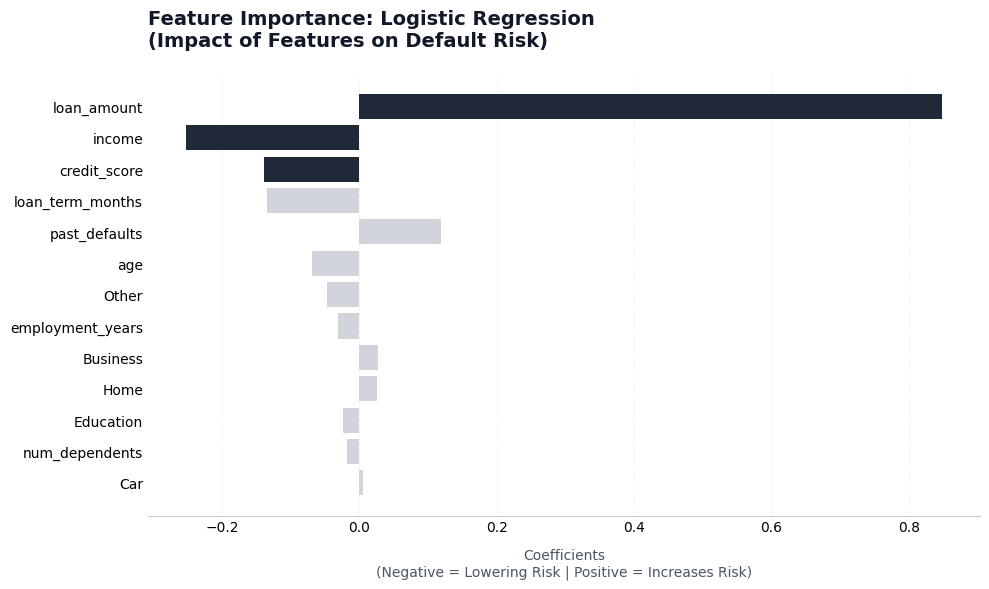

In [694]:
feature_names = X_train.columns
coefficients = model_lr.coef_[0]

df_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

df_coef = df_coef.sort_values(by='Abs_Coefficient', ascending=True).reset_index(drop=True)

colors = ['#d1d5db'] * (len(df_coef) - 3) + ['#1f2937'] * 3 

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_coef['Feature'], df_coef['Coefficient'], color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#cccccc')

ax.tick_params(axis='both', which='both', length=0)

ax.xaxis.grid(True, linestyle='--', alpha=0.6, color='#eeeeee')
ax.set_axisbelow(True)

plt.title('Feature Importance: Logistic Regression\n(Impact of Features on Default Risk)', 
          fontsize=14, fontweight='bold', loc='left', pad=20, color='#111827')
plt.xlabel('Coefficients\n(Negative = Lowering Risk | Positive = Increases Risk)', 
           fontsize=10, color='#4b5563', labelpad=10)

# Render grafik
plt.tight_layout()
plt.show()

In [695]:
print("List of Features and Their Coefficient Values:")
print("-" * 35)

for index, row in df_coef.sort_values(by='Abs_Coefficient', ascending=False).iterrows():
    print(f"{row['Feature']:<20} : {row['Coefficient']:.4f}")

List of Features and Their Coefficient Values:
-----------------------------------
loan_amount          : 0.8486
income               : -0.2530
credit_score         : -0.1383
loan_term_months     : -0.1349
past_defaults        : 0.1190
age                  : -0.0687
Other                : -0.0476
employment_years     : -0.0307
Business             : 0.0272
Home                 : 0.0257
Education            : -0.0246
num_dependents       : -0.0185
Car                  : 0.0053
